In [3]:
import polars as pl
import pandas as pd
import pyarrow
import matplotlib.pyplot as plt
import numpy as np

In [4]:
def read_tsv_with_polars(file_path, column_names, column_types, null_values=['\\N']):
    """
    Reads a TSV file into a Polars DataFrame with specified column names and types.

    Parameters:
    file_path (str): Path to the TSV file.
    column_names (list): List of column names.
    column_types (list): List of Polars data types for the columns.
    null_values (list, optional): List of strings to be treated as null values. Defaults to ['\\N'].

    Returns:
    pl.DataFrame: Polars DataFrame with the TSV data.
    """
    # Set the format string lengths for display
    pl.Config.set_fmt_str_lengths(50)

    # Read the TSV file
    df = pl.read_csv(
        file_path,
        separator='\t',
        has_header=False,
        new_columns=column_names,
        dtypes=column_types,
        ignore_errors=True,
        null_values=null_values,
        skip_rows=1
    )
    return df

In [7]:
ratings_df = read_tsv_with_polars("./raw_data/title.ratings.tsv", ['const', 'averageRating', 'numVotes'], [pl.Utf8, pl.Float32, pl.Int32])


In [ ]:
# ratings_df = ratings_df.with_columns(pl.col("averageRating").cast(pl.Float32, strict=False))

In [8]:
ratings_df.head(10)

const,averageRating,numVotes
str,f32,i32
"""tt0000001""",5.7,2012
"""tt0000002""",5.7,271
"""tt0000003""",6.5,1931
"""tt0000004""",5.4,179
"""tt0000005""",6.2,2703
"""tt0000006""",5.0,183
"""tt0000007""",5.4,842
"""tt0000008""",5.4,2157
"""tt0000009""",5.3,207


In [ ]:
column_names = ['const', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult', 
                'startYear', 'endYear', 'runtimeMinutes', 'genres']

# Define column types
# Adjust these based on the actual data in each column
column_types = [pl.Utf8, pl.Utf8, pl.Utf8, pl.Utf8, pl.Int32, 
                pl.Int32, pl.Int32, pl.Int32, pl.Utf8]

basics_df = read_tsv_with_polars('./title.basics.tsv', column_names, column_types)

In [ ]:
basics_df["titleType"].value_counts()

titleType,count
str,u32
"""tvEpisode""",7959971
"""videoGame""",36867
"""tvSeries""",254231
"""tvMovie""",143791
"""tvMiniSeries""",51628
"""video""",284855
"""movie""",666663
"""tvShort""",10132
"""short""",968320


In [ ]:
filter_condition = basics_df['titleType'] == "movie"

movies = basics_df.filter(filter_condition)

In [ ]:
movies.columns

['const',
 'titleType',
 'primaryTitle',
 'originalTitle',
 'isAdult',
 'startYear',
 'endYear',
 'runtimeMinutes',
 'genres']

In [ ]:
movie_ratings = movies.join(ratings_df, on="const", how="inner")

movie_ratings.head()

const,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
str,str,str,str,i32,i32,i32,i32,str,f32,i32
"""tt0000009""","""movie""","""Miss Jerry""","""Miss Jerry""",0,1894,null,45,"""Romance""",5.3,207
"""tt0000147""","""movie""","""The Corbett-Fitzsimmons Fight""","""The Corbett-Fitzsimmons Fight""",0,1897,null,100,"""Documentary,News,Sport""",5.3,489
"""tt0000502""","""movie""","""Bohemios""","""Bohemios""",0,1905,null,100,null,4.1,15
"""tt0000574""","""movie""","""The Story of the Kelly Gang""","""The Story of the Kelly Gang""",0,1906,null,70,"""Action,Adventure,Biography""",6.0,861
"""tt0000591""","""movie""","""The Prodigal Son""","""L'enfant prodigue""",0,1907,null,90,"""Drama""",5.0,21


In [ ]:
movie_ratings = movie_ratings.filter(movie_ratings['startYear'].is_not_null())
movie_ratings['startYear'].value_counts(sort=True)

startYear,count
i32,u32
2019,10478
2018,10358
2017,10288
2022,10035
2016,9807
2015,9421
2014,9193
2021,8886
2013,8567


In [ ]:
movies_2023 = movie_ratings.filter(pl.col('startYear') == 2023)

In [ ]:
movie_ratings = movie_ratings.filter(pl.col("numVotes") > 10000)

movie_ratings.shape

(10893, 11)

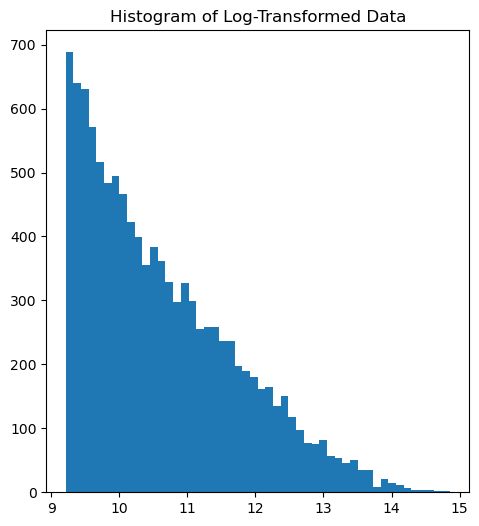

In [ ]:
movies_pd = movie_ratings.to_pandas()


# movies_pd.hist(column='numVotes', bins=100)

# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.hist(movies_pd['numVotes'], bins=100)
# plt.yscale('log')
# plt.title('Histogram with Logarithmic Scale')
# plt.show()

# Histogram of log-transformed data
movies_pd['log_transformed'] = np.log(movies_pd['numVotes'])
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.hist(movies_pd['log_transformed'], bins=50)
plt.title('Histogram of Log-Transformed Data')
plt.show()

In [ ]:
movie_ratings.sort('averageRating', descending=True)

movie_ratings.write_parquet('./data/movies_with_ratings.parquet')